# Preprocessing

In [1]:
import pickle
import json
import os
from preprocessing import clean_gt, clean_raw, label_entity

In [2]:
split = pickle.load(open('data/train_test_eval_filenames_new.pkl', 'rb'))
split

{'train': ['sbz-002_1940_115_0223.txt',
  'dkm-001_1941_001_0431.txt',
  'dkm-001_1941_001_0438.txt',
  'dkm-001_1941_001_0441.txt',
  'sbz-002_1940_115_0222.txt',
  'sbz-002_1965_083_3175.txt',
  'sbz-002_1940_115_0224.txt',
  'sbz-002_1895_025_0676.txt',
  'sbz-002_1940_115_0218.txt',
  'sbz-002_1895_025_0679.txt',
  'dkm-003_2010_070_0050.txt',
  'sbz-002_1940_115_0221.txt',
  'sbz-004_2010_136_0884.txt',
  'sbz-002_1940_115_0220.txt',
  'sbz-002_1965_083_3184.txt',
  'sbz-002_1895_025_0678.txt',
  'sbz-002_1965_083_3188.txt',
  'dkm-001_1941_001_0423.txt',
  'sbz-004_2010_136_0887.txt',
  'sbz-004_2010_136_0890.txt',
  'dkm-003_2010_070_0053.txt',
  'dkm-001_1941_001_0434.txt',
  'sbz-004_2010_136_0883.txt',
  'sbz-004_2010_136_0882.txt',
  'sbz-002_1965_083_3178.txt',
  'dkm-001_1941_001_0430.txt',
  'dkm-003_2010_070_0056.txt',
  'sbz-004_2010_136_0885.txt',
  'sbz-002_1965_083_3173.txt',
  'sbz-002_1965_083_3172.txt',
  'sbz-002_1965_083_3180.txt',
  'dkm-001_1941_001_0433.txt',

In [3]:
#train = 94, test = 30, eval = 10

In [4]:
# import random
# new_split = {"train":[], "test": [], "eval": []}
# for key in split:
#     for page in split[key]:
#         mag = page.split("_")[0].split("-")[0]
#         year = page.split("_")[1]
        
#         if mag == "dkm" and (year == "1941" or year == "2010"):
#             new_split["train"].append(page)
#         if (year == "1990"):
#             new_split["test"].append(page)
#         if mag =="sbz" and (year == "1895" or year == "1940" or year == "1965" or year == "2010"):
#             new_split["train"].append(page)

# eval_set = random.sample(new_split["train"], int(len(new_split["train"])/10)) #set 10% of train aside for eval
# for page in eval_set:
#     new_split["train"].remove(page)
# new_split["eval"] = eval_set

# with open('train_test_eval_filenames_new.pkl', 'wb') as out:
#     pickle.dump(new_split, out)

In [5]:
"""
data = {
    "train": [],
    "test": [],
    "eval": []
}
gt_data = []
for mag in ["dkm", "sbz"]:
    for year in os.listdir(f'data/raw/link/{mag}'):
        with open(os.path.join("data/raw/link", mag, year)) as f:
            input_linked = json.load(f)
        with open(os.path.join("data/ground-truth", mag, year)) as f:
            gt = json.load(f)
        gt = clean_gt(gt)
        gt_data += gt
        input_linked = clean_raw(input_linked)

        #due to non-determinism in the flair NER:
        all_refs_gt = [g["page"]+g["coord"] for g in gt] 
        all_refs_linked = [ent["page"]+ent["coord"] for l in input_linked for ent in l]
        all_valid_refs = set(all_refs_gt).intersection(set(all_refs_linked))

        for ent_variations in input_linked:
            for key in split:
                ent_instances = []
                for ent in ent_variations:
                    if ent["page"] in split[key]:
                        if (ent["page"]+ent["coord"]) in all_valid_refs:
                            ent_instances.append({"ent": ent, "label": label_entity(ent, gt)})
                if ent_instances:
                    data[key].append(ent_instances)
"""

'\ndata = {\n    "train": [],\n    "test": [],\n    "eval": []\n}\ngt_data = []\nfor mag in ["dkm", "sbz"]:\n    for year in os.listdir(f\'data/raw/link/{mag}\'):\n        with open(os.path.join("data/raw/link", mag, year)) as f:\n            input_linked = json.load(f)\n        with open(os.path.join("data/ground-truth", mag, year)) as f:\n            gt = json.load(f)\n        gt = clean_gt(gt)\n        gt_data += gt\n        input_linked = clean_raw(input_linked)\n\n        #due to non-determinism in the flair NER:\n        all_refs_gt = [g["page"]+g["coord"] for g in gt] \n        all_refs_linked = [ent["page"]+ent["coord"] for l in input_linked for ent in l]\n        all_valid_refs = set(all_refs_gt).intersection(set(all_refs_linked))\n\n        for ent_variations in input_linked:\n            for key in split:\n                ent_instances = []\n                for ent in ent_variations:\n                    if ent["page"] in split[key]:\n                        if (ent["page"]+

In [6]:
"""
with open("data/processed.pkl", "wb") as f:
    pickle.dump(data, f)
"""

'\nwith open("data/processed.pkl", "wb") as f:\n    pickle.dump(data, f)\n'

# Candidate Generation

In [7]:
import pickle
from tqdm.notebook import  tqdm
from candidate_generation import create_metagrid_candidates

In [8]:
def remove_obsolete_abbrevs(fnames, abbr_firstname, prep_for_query=True):
    """
    Remove abbreviated firstnames, that are already covered by full firstnames.
    e.g. fnames = ["R.", "Richard"] => fnames = ["Richard"]
    """
    cleaned_abbr_fnames = []
    for abbr_group in abbr_firstname:  # this is now a list
        cleaned_abbr_group = []
        for abbr in abbr_group:
            is_obsolete = False
            abbr = abbr.rstrip(".")
            for fname in fnames:
                if fname.startswith(abbr):
                    is_obsolete = True
            if not is_obsolete:
                if prep_for_query:
                    cleaned_abbr_group.append(abbr + "*")
                else:
                    cleaned_abbr_group.append(abbr + ".")
        cleaned_abbr_fnames.append(cleaned_abbr_group)
    
    return cleaned_abbr_fnames


In [9]:
import SPARQLWrapper
from SPARQLWrapper import JSON, SPARQLExceptions, SPARQLWrapper
import pprint as pp
def get_candidates_fuseki(person):
    """
    Call the RDF library to find candidates.
    Note to self: Consider limiting the query to top X answers if querying times are slow.
    """
    #unfortunately, checks like the one below doesn't find people like "Beethoven"
    if len(person["lastname"]) == 0 or (len([c for x in " ".join(person["lastname"]) for c in x]) < 2) or (not person["firstname"] and not person["abbr_firstname"]):
        return {}

    fnames = person["firstname"].split(" ")
    print(fnames)
    #fnames = list(set([x for y in fnames for x in y]))
    abbr_fnames = remove_obsolete_abbrevs(fnames, person["abbr_firstname"])
    abbr_fnames = list(set([x for y in abbr_fnames for x in y if x!="*"]))
    #abbr_fnames = " ".join(abbr_fnames)
    print(abbr_fnames)

    lastname = person["lastname"].split(" ")
    print(lastname)
    if fnames == [""]:
        names = " AND ".join(abbr_fnames + lastname)
    else:
        names = " AND ".join(fnames + abbr_fnames + lastname)
    print(names)
    if(len(lastname) > 1):
        lastname = " ".join(lastname)
    else:
        lastname = lastname[0]
    pref_names_format = lastname + ", " + " ".join(fnames) 
    query_string = """
        PREFIX gndo: <https://d-nb.info/standards/elementset/gnd#>
        PREFIX text: <http://jena.apache.org/text#>
        SELECT *
        WHERE {{
            {{?x text:query "{0}" . }}
            UNION
            {{?x text:query (gndo:variantNameForThePerson "{0}") . }}
            UNION
            {{?x gndo:preferredNameForThePerson ?s .
            FILTER (?s = "{1}") . }}
            ?x a gndo:DifferentiatedPerson .
            ?x gndo:gndIdentifier ?gid .
            ?x gndo:preferredNameEntityForThePerson ?name .
            OPTIONAL {{ ?name gndo:prefferedNameForThePerson ?prefVarName . }}
            OPTIONAL {{ ?name gndo:forename ?prefForename . }}
            OPTIONAL {{ ?name gndo:prefix ?prefPrefix . }}
            OPTIONAL {{ ?name gndo:surname ?prefSurname . }}
            OPTIONAL {{ ?name gndo:personalName ?prefPersName . }}
            OPTIONAL {{ ?name gndo:nameAddition ?prefNameAddition . }}
            OPTIONAL {{ ?x gndo:variantNameEntityForThePerson ?y . 
                OPTIONAL {{ ?y gndo:variantNameForThePerson ?varName . }}
                OPTIONAL {{ ?y gndo:forename ?varForename . }}
                OPTIONAL {{ ?y gndo:prefix ?varPrefix . }}
                OPTIONAL {{ ?y gndo:surname ?varSurname . }}
                OPTIONAL {{ ?y gndo:personalName ?varPersName . }}
                OPTIONAL {{ ?y gndo:nameAddition ?varNameAddition . }}
            }}
            OPTIONAL {{ ?x gndo:professionOrOccupationAsLiteral ?jobliteral . }}
            OPTIONAL {{ ?x gndo:gndSubjectCategory ?category . }}
            OPTIONAL {{ ?x gndo:academicDegree ?academic . }}
            OPTIONAL {{ ?x gndo:professionOrOccupation ?job . }}
            OPTIONAL {{ ?x gndo:dateOfBirth ?birthdate . }}
            OPTIONAL {{ ?x gndo:dateOfDeath ?deathdate . }}
            OPTIONAL {{ ?x gndo:placeOfBirth ?birthplace . }}
            OPTIONAL {{ ?x gndo:placeOfDeath ?deathplace . }}
            OPTIONAL {{ ?x gndo:placeOfBirthAsLiteral ?birthplaceLiteral . }}
            OPTIONAL {{ ?x gndo:placeOfDeathAsLiteral ?deathplaceLiteral . }}
            OPTIONAL {{ ?x gndo:placeOfActivity ?activeplace . }}
            OPTIONAL {{ ?x gndo:periodOfActivity ?activeperiod . }}
            OPTIONAL {{ ?x gndo:biographicalOrHistoricalInformation ?desc . }}
            OPTIONAL {{ ?x gndo:geographicAreaCode ?generalArea . }}
            OPTIONAL {{ ?x gndo:affiliationAsLiteral ?affiliationLiteral . }}
        }}
        """.format(names, pref_names_format)
    endpoint = SPARQLWrapper("http://localhost:3030/persondata")
    endpoint.setQuery(query_string)
    endpoint.setReturnFormat(JSON)

    #print(query_string)
    try:
        results = endpoint.query().convert()
    except SPARQLExceptions.EndPointInternalError:
        pp.pprint("Invalid query")
        pp.pprint(query_string)
        #import sys;sys.exit()
        return {}
    except json.decoder.JSONDecodeError as e:
        pp.pprint(e)
        pp.pprint("Couldn't decode answer!")
        pp.pprint(query_string)
        return {}

    results = results["results"]["bindings"]
    if len(results) == 0:
        print("results is empty")
        print(names)
        #sys.exit()
        return {}
    else:
        print("sucessfully linked")
        #print(results)
   
    unique_candidate_dict = {}
    for result in results:
        uid = result["gid"]["value"]
        unique_candidate_dict.setdefault(uid, dict())
        for attname, attvalue in result.items():
            unique_candidate_dict[uid].setdefault(attname,set()).add(attvalue["value"])
    #now prepare the candidates the same way he did for metagrid:
    
    #print(unique_candidate_dict)
    return unique_candidate_dict


In [10]:
import requests, json
def extract_field_by_gnd(field, gnd_id, is_per = False):
    lobid_url = "http://lobid.org/gnd/"+gnd_id+".json"
    try:
        res = requests.get(lobid_url, timeout=5)
    except requests.ReadTimeout:
        return ""
    if (res.status_code != 200):
        return ""
    try:
        lobid_json = json.loads(res.text)
    except ValueError:
        print("this url: "+ lobid_url + " threw a json decode error")
        return ""
    if is_per:
        print(lobid_json.keys())
        field_list = []
        for i in lobid_json[field]:
            field_list.append(i["label"])
        return field_list
    else:
        #profession and place gnds
        return lobid_json["preferredName"]


In [11]:
import regex as re
from candidate_generation import get_coords_from_candidate
def process_fuseki_candidates(candidates):
    """
    fuseki candidates are given to us in the form:
    candidates created via fuseki is a dictionary with key gnd_id and the values are sets.
    example
    116272295
        "x" : {'https://d-nb.info/gn.../116272295'}
        "gid" : {'116272295'}
        "name" : {'b0'}
        "prefForename": {'Otto'}
        "prefSurname": {'Ahrens'}
        "y": {'b1'}
        "varForename": {'O.'}
        "varSurname": {'Ahrens'}
        "job": {'https://d-nb.info/gn.../4044300-0'}
        "activeplace":{'https://d-nb.info/gn.../4749047-0'}
        "activeperiod":{'1897'}
        "desc":{'Verf. von Mecklenburgica'}
        "generalArea":{'https://d-nb.info/st...code#XA-DE'}
    and depending on the info we have even more than this (birthdate, deathdate etc)
    """
    candidate_list = []

    for gnd_id in candidates:
        curr_cand = dict()
        curr_cand["Gnd"] = gnd_id

        curr_cand["PrefName"] = []
        curr_cand["FirstName"] = []
        curr_cand["LastName"] = []

        if "prefForename" in candidates[gnd_id]:
            firstnames_list = list(candidates[gnd_id]["prefForename"])
            curr_cand["FirstName"] += firstnames_list
        if "prefSurname" in candidates[gnd_id]:
            lastnames_list = list(candidates[gnd_id]["prefSurname"])
            curr_cand["LastName"] += lastnames_list
        
        if  "prefForename" in candidates[gnd_id] and "prefSurname" in candidates[gnd_id]:
            curr_cand["PrefName"] = [" ".join(curr_cand["LastName"]) + ", " + " ".join(curr_cand["FirstName"])]
        
        if curr_cand["FirstName"] == []:
            if "varForename" in candidates[gnd_id]:
                varfirstnames_list = list(candidates[gnd_id]["varForename"])
                curr_cand["FirstName"] += varfirstnames_list
        if curr_cand["LastName"] == []:
            if "varSurname" in candidates[gnd_id]:
                varlastnames_list = list(candidates[gnd_id]["varSurname"])
                curr_cand["LastName"] += varlastnames_list
        #we do not set prefName according to the varnames even if we have no prefnames.
        
        #take care of duplicates
        curr_cand["LastName"] = list(set(curr_cand["LastName"]))
        curr_cand["FirstName"] = list(set(curr_cand["FirstName"]))

        curr_cand["Biography"] = []
        if "desc" in candidates[gnd_id]:
            for i in candidates[gnd_id]["desc"]:
                curr_cand["Biography"].append(i)
        
        curr_cand["Places"] = []
        if "activeplace" in candidates[gnd_id]:
            for i in candidates[gnd_id]["activeplace"]:
                activeplace = extract_field_by_gnd("placeOfActivity", i.split("/")[-1], False)
                if activeplace != "":
                    curr_cand["Places"].append(activeplace)
        if "birthplace" in candidates[gnd_id]:
            for i in candidates[gnd_id]["birthplace"]:
                birthplace = extract_field_by_gnd("placeOfBirth", i.split("/")[-1], False)
                if birthplace != "":
                    curr_cand["Places"].append(birthplace)
        if "deathplace" in candidates[gnd_id]:
            for i in candidates[gnd_id]["deathplace"]:
                deathplace = extract_field_by_gnd("placeOfDeath", i.split("/")[-1], False)
                if deathplace != "":
                    curr_cand["Places"] .append(deathplace)
        if "generalArea" in candidates[gnd_id]:
            for i in candidates[gnd_id]["generalArea"]:
                general_area = extract_field_by_gnd("geographicAreaCode", i.split("/")[-1], False)
                if general_area != "":
                    curr_cand["Places"].append(general_area)
        
        curr_cand["Professions"] = []
        if "job" in candidates[gnd_id]:
            for i in candidates[gnd_id]["job"]:
                curr_job = extract_field_by_gnd("professionOrOccupation", i.split("/")[-1], False)
                curr_cand["Professions"].append(curr_job)
        
        curr_cand["Death Year"] = 0
        if "deathdate" in candidates[gnd_id]:
            dates = " ".join(candidates[gnd_id]["deathdate"])
            year_regex = re.findall(r'\d{4}', dates)
            year_regex.sort()
            if (len(year_regex) != 0):
                curr_cand["Death Year"] = int(year_regex[-1])
        curr_cand["Birth Year"] = 0
        if "birthdate" in candidates[gnd_id]:
            dates = " ".join(candidates[gnd_id]["birthdate"])
            year_regex = re.findall(r'\d{4}', dates)
            year_regex.sort()
            if (len(year_regex) != 0):
                curr_cand["Birth Year"] = int(year_regex[0])
                   
        curr_cand.update(get_coords_from_candidate(curr_cand))

        candidate_list.append(curr_cand)
    #and append the empty candidate
    empty_candidate = {'Gnd': '',
                        'PrefName': [],
                        'FirstName': [],
                        'LastName': [],
                        'Biography': [],
                        'Places': [],
                        'Professions': [],
                        'Death Year': 0,
                        'Birth Year': 0,
                        'coordinates': []}
    candidate_list.append(empty_candidate)
    return candidate_list


In [24]:
from multiprocessing import Pool

# load everytime you run this as we pop keys to keep data clean..
with open("data/processed.pkl", "rb") as f:
    data = pickle.load(f)

def worker_func(params):
    entity_list, counter = params
    print('Worker' + str(counter))
    
    # Create candidates only for the first entry in the list as all the entity information is always the same
    # The only thing that changes are pages and page_coordinates
    candidates = create_metagrid_candidates(ent=entity_list[0]["ent"])
    # Generate the list of page_coordinates and the corresponding labels!
    coord_list = []
    label_list = []
    for ent_dict in entity_list:
        ent = ent_dict["ent"]
        coord_list.append({
            "page": ent.pop("page", ""), 
            "coords": ent.pop("coord", "")
        })
        label_list.append(ent_dict["label"])
    
    return {"entity": ent, "candidates": candidates, "occurences": coord_list, "labels": label_list}
    

    
for split in ["train", "eval", "test"]:
    ent_cand_label = []
    i = 0
    with Pool(64) as pool:
        ent_cand_label = pool.map(worker_func, zip(data[split], range(len(data[split]))))
                    
    with open(f"candidates-gnd-{split}.pkl", "wb") as f:
        pickle.dump(ent_cand_label, f)

Worker9Worker0Worker18Worker6Worker15Worker24Worker30Worker12Worker33Worker42Worker21

Worker57Worker39Worker3Worker60Worker54

Worker66Worker63Worker69Worker48
Worker84

Worker72Worker75

Worker51Worker81Worker45

Worker78


Worker36


Worker27
Worker87





Worker90
Worker93
Worker105Worker99Worker102


Worker96
Worker111

Worker108




Worker129Worker120Worker126Worker114Worker117Worker141Worker135Worker123Worker153Worker159Worker171Worker162Worker144Worker150
Worker165Worker156Worker168
Worker147

Worker177Worker138Worker180



Worker186





Worker174
Worker189
Worker132



Worker183






Worker28
Worker31
Worker85Worker10

Worker25
Worker22
Worker52
Worker118
Worker86
Worker192
Worker43
Worker100
Worker112
Worker88
Worker160
Worker4
Worker163
Worker58
Worker59
Worker130
Worker49
Worker70Worker34Worker97Worker94



Worker32
Worker103Worker187

Worker193
Worker89Worker37

Worker164
Worker1
Worker76
Worker133
Worker106
Worker145
Worker77
Worker107
Worker146
Worker195Worker29

Worke

# Feature Generation

In [39]:
with open(f"candidates-gnd-train.pkl", "rb") as f:
    ent_cand_label = pickle.load(f)

ent_cand_label[4]

{'entity': {'lastname': '',
  'firstname': '',
  'abbr_firstname': [],
  'other': [['Frau', 'M.']],
  'name': 'Frau M.',
  'profession': [],
  'places': ['Nordschweiz'],
  'year': '1941'},
 'candidates': [{'Gnd': '128356138',
   'PrefName': ['M. M. R. P. L.'],
   'FirstName': [],
   'LastName': [],
   'Biography': [],
   'Places': [],
   'Professions': [],
   'Death Year': 0,
   'Birth Year': 0,
   'coordinates': []},
  {'Gnd': '131864211',
   'PrefName': ['M. M. W.'],
   'FirstName': [],
   'LastName': [],
   'Biography': ['vermutl. aus Zittau; Verfasser eines Glückwunschgedichts zu einer Hochzeit'],
   'Places': [],
   'Professions': [],
   'Death Year': 0,
   'Birth Year': 0,
   'coordinates': []},
  {'Gnd': '1077870809',
   'PrefName': ['M. M. M.'],
   'FirstName': ['M. M.'],
   'LastName': ['M', 'a', 'n', 's', 'u', 'g'],
   'Biography': [],
   'Places': ['Deutschland'],
   'Professions': [],
   'Death Year': 0,
   'Birth Year': 0,
   'coordinates': [None]},
  {'Gnd': '122457138X',

### To get the relevant fastttext model uncomment and run the following cell

In [44]:
from gensim.models.fasttext import FastText, load_facebook_vectors
model = load_facebook_vectors("cc.de.300.bin/cc.de.300.bin")
model.save("./fasttext")

In [45]:
import pickle
from tqdm.notebook import  tqdm
from feature_generation import candidates_to_features

In [58]:
#AF:
from tqdm import tqdm
# load everytime you run this as we pop keys to keep data clean..
with open("data/processed.pkl", "rb") as f:
    data = pickle.load(f)

problematic_entities = []
# TODO -> enable this one!
# for split in ["train", "eval", "test"]:
# for split in ["train", "test"]:
for split in ["eval"]:
    ent_cand_label = []
    i = 0
    for entity_list in tqdm(data[split], smoothing=0.01):
        i += 1
        # Create candidates only for the first entry in the list as all the entity information is always the same
        # The only thing that changes are pages and page_coordinates
        
        #fuseki:
        unique_candidate_dict = get_candidates_fuseki(entity_list[0]["ent"])
        candidates = process_fuseki_candidates(unique_candidate_dict)
        #print(process_fuseki_candidates(unique_candidate_dict))
        #list_of_tuples.append((ent, processed_fuseki_cands, ent_dict["label"]))
        
        #metagrid
        ## candidates = create_metagrid_candidates(ent=entity_list[0]["ent"])
        # Generate the list of page_coordinates and the corresponding labels!
        coord_list = []
        gt_label = []
        for ent_dict in entity_list:
            ent = ent_dict["ent"]
            coord_list.append({
                "page": ent.pop("page", ""), 
                "coords": ent.pop("coord", "")
            })
            gt_label.append(ent_dict["label"])

        #if len(gt_label)!=1:
        #    problematic_entities.append({"ent_list": entity_list, "gt_labels": gt_label, "mag": coord_list})
            

        #gt_label = gt_label.pop()
        
        ent_cand_label.append({"entity": ent, "candidates": candidates, "occurences": coord_list, "gt_label": gt_label})
        if i % 100 == 0:
            with open(f"data/candidates/candidates-gnd-{split}-{i}.pkl", "wb") as f:
                pickle.dump(ent_cand_label, f)
                    
    with open(f"data/candidates/candidates-gnd-{split}.pkl", "wb") as f:
        pickle.dump(ent_cand_label, f)
print(problematic_entities)


  0%|                                                                                                                                                              | 0/49 [00:00<?, ?it/s]

['Gretel']
[]
['Adorno']
Gretel AND Adorno
sucessfully linked


 12%|██████████████████▎                                                                                                                                   | 6/49 [00:00<00:03, 12.71it/s]

['Egon']
[]
['Ammann']
Egon AND Ammann
sucessfully linked
['Dieter']
[]
['Bachmann']
Dieter AND Bachmann
sucessfully linked


 16%|████████████████████████▍                                                                                                                             | 8/49 [00:02<00:11,  3.71it/s]

['Ingeborg']
[]
['Bachmann']
Ingeborg AND Bachmann
sucessfully linked


 18%|███████████████████████████▌                                                                                                                          | 9/49 [00:03<00:14,  2.75it/s]

['Ulla']
[]
['Berkéwicz']
Ulla AND Berkéwicz
sucessfully linked


 22%|█████████████████████████████████▍                                                                                                                   | 11/49 [00:03<00:13,  2.86it/s]

['Elisabeth']
[]
['Borchers']
Elisabeth AND Borchers
sucessfully linked


 24%|████████████████████████████████████▍                                                                                                                | 12/49 [00:04<00:13,  2.68it/s]

['Gion', 'Mathias']
[]
['Cavelty']
Gion AND Mathias AND Cavelty
sucessfully linked


 27%|███████████████████████████████████████▌                                                                                                             | 13/49 [00:04<00:13,  2.72it/s]

['Sven']
[]
['Epiney']
Sven AND Epiney
results is empty
Sven AND Epiney
['Piero']
[]
['Esteriore']
Piero AND Esteriore
sucessfully linked


 31%|█████████████████████████████████████████████▌                                                                                                       | 15/49 [00:04<00:11,  3.02it/s]

['Willy']
[]
['Fleckhaus']
Willy AND Fleckhaus
sucessfully linked


 33%|████████████████████████████████████████████████▋                                                                                                    | 16/49 [00:05<00:11,  2.84it/s]

['Max']
[]
['Frisch']
Max AND Frisch
sucessfully linked


 35%|███████████████████████████████████████████████████▋                                                                                                 | 17/49 [00:06<00:13,  2.45it/s]

['Navid']
[]
['Kermani']
Navid AND Kermani
sucessfully linked


 39%|█████████████████████████████████████████████████████████▊                                                                                           | 19/49 [00:08<00:13,  2.21it/s]

['Hans-Michael']
[]
['Koetzle']
Hans-Michael AND Koetzle
sucessfully linked


 41%|████████████████████████████████████████████████████████████▊                                                                                        | 20/49 [00:09<00:13,  2.18it/s]

['Mani']
[]
['Matter']
Mani AND Matter
sucessfully linked


 43%|███████████████████████████████████████████████████████████████▊                                                                                     | 21/49 [00:09<00:13,  2.14it/s]

['Nikiaus']
[]
['Meienberg']
Nikiaus AND Meienberg
results is empty
Nikiaus AND Meienberg
['Paul']
[]
['Nizon']
Paul AND Nizon
sucessfully linked


 49%|████████████████████████████████████████████████████████████████████████▉                                                                            | 24/49 [00:10<00:10,  2.28it/s]

['Andri']
[]
['Pol']
Andri AND Pol
sucessfully linked
['Peter']
[]
['Reinhart']
Peter AND Reinhart
sucessfully linked


 51%|████████████████████████████████████████████████████████████████████████████                                                                         | 25/49 [00:11<00:10,  2.23it/s]

['David']
[]
['Signer']
David AND Signer
sucessfully linked


 53%|███████████████████████████████████████████████████████████████████████████████                                                                      | 26/49 [00:11<00:10,  2.26it/s]

['Peter']
[]
['Suhrkamp']
Peter AND Suhrkamp
sucessfully linked


 55%|██████████████████████████████████████████████████████████████████████████████████                                                                   | 27/49 [00:12<00:09,  2.22it/s]

['Siegfried']
[]
['Unseld']
Siegfried AND Unseld
sucessfully linked


 57%|█████████████████████████████████████████████████████████████████████████████████████▏                                                               | 28/49 [00:12<00:09,  2.19it/s]

['Hans-Ulrich']
[]
['Zbinden']
Hans-Ulrich AND Zbinden
sucessfully linked


 61%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 30/49 [00:13<00:08,  2.15it/s]

['']
['R*', 'b*', 'o*']
['Helbling']
R* AND b* AND o* AND Helbling
results is empty
R* AND b* AND o* AND Helbling
['Daniela']
[]
['Dietsche']
Daniela AND Dietsche
sucessfully linked


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 33/49 [00:14<00:06,  2.35it/s]

['Jul']
[]
['Bachmann']
Jul AND Bachmann
sucessfully linked
['']
['C*']
['Doxiades']
C* AND Doxiades
results is empty
C* AND Doxiades
['Jean']
[]
['Dubuisson']
Jean AND Dubuisson
sucessfully linked


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 34/49 [00:14<00:06,  2.36it/s]

['Etienne']
[]
['Dusart']
Etienne AND Dusart
results is empty
Etienne AND Dusart
['Jürg']
[]
['Lang']
Jürg AND Lang
sucessfully linked


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 37/49 [00:14<00:04,  2.51it/s]

['Kunio']
[]
['Maekawa']
Kunio AND Maekawa
sucessfully linked
['Mohamed']
['S*']
['Makiya']
Mohamed AND S* AND Makiya
sucessfully linked


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 40/49 [00:15<00:03,  2.62it/s]

['Andres']
[]
['Nydegger']
Andres AND Nydegger
results is empty
Andres AND Nydegger
['Igor']
[]
['Rogii']
Igor AND Rogii
results is empty
Igor AND Rogii
['Gorm']
[]
['Schmidt']
Gorm AND Schmidt
results is empty
Gorm AND Schmidt
['Karl']
[]
['Schwanzer']
Karl AND Schwanzer
sucessfully linked


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 42/49 [00:16<00:02,  2.62it/s]

['Jose', 'Luis']
[]
['Sert']
Jose AND Luis AND Sert
results is empty
Jose AND Luis AND Sert
['Heikki']
[]
['Siren']
Heikki AND Siren
sucessfully linked


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 48/49 [00:16<00:00,  2.97it/s]

['']
['G*']
['Westinghouse']
G* AND Westinghouse
sucessfully linked
['']
['J*']
['Wheless']
J* AND Wheless


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:16<00:00,  2.93it/s]

results is empty
J* AND Wheless
[]


# Feature Generation

In [48]:
from gensim.models.fasttext import FastText, load_facebook_vectors

In [49]:
#model = load_facebook_vectors("cc.de.300.bin/cc.de.300.bin")

In [50]:
#model.save("./fasttext")
ent_cand_label[0]

{'entity': {'lastname': '',
  'firstname': 'Bernhard',
  'abbr_firstname': [],
  'other': [],
  'name': None,
  'profession': [],
  'places': ['Wawa',
   'Welt',
   'Wertheimer',
   'Polarkreises',
   'New York',
   'Leopoldskron',
   'Toronto'],
  'year': '1990'},
 'candidates': [{'Gnd': '',
   'PrefName': [],
   'FirstName': [],
   'LastName': [],
   'Biography': [],
   'Places': [],
   'Professions': [],
   'Death Year': 0,
   'Birth Year': 0,
   'coordinates': []}],
 'occurences': [{'page': 'dkm-003_1990_050_0382.txt',
   'coords': '700,2044,68,25'},
  {'page': 'dkm-003_1990_050_0382.txt', 'coords': '136,2089,55,28'},
  {'page': 'dkm-003_1990_050_0382.txt', 'coords': '879,726,115,28'},
  {'page': 'dkm-003_1990_050_0382.txt', 'coords': '1273,2775,116,28'},
  {'page': 'dkm-003_1990_050_0382.txt', 'coords': '135,2862,126,28'},
  {'page': 'dkm-003_1990_050_0382.txt', 'coords': '967,1675,127,28'},
  {'page': 'dkm-003_1990_050_0382.txt', 'coords': '1066,1995,127,28'},
  {'page': 'dkm-003

In [51]:
import pickle
from tqdm import  tqdm
from feature_generation import create_features, get_gnd

In [59]:
for split in ["train", "eval", "test"]:
#for split in ["eval"]:
    with open(f"data/candidates/candidates-gnd-{split}.pkl", "rb") as f:
        ent_cand_label = pickle.load(f)

    list_of_good_entities = []
    list_of_problematic_entities = []
    for ent_dict in tqdm(ent_cand_label):
        # we only consider the ones with label!
        # why do we set > 1 but not > 0???
#         import pdb; pdb.set_trace()
        if len(set(ent_dict["gt_label"])) > 1:
            for label in set(ent_dict["gt_label"]):
                ent_dict["label"] = label
                features = candidates_to_features(ent=ent_dict["entity"], candidates=ent_dict["candidates"], gt_label=ent_dict["label"])
                ent_dict.update(features)
                list_of_problematic_entities.append(ent_dict.copy())
        else:
            ent_dict["label"] = set(ent_dict["gt_label"]).pop()
            features = candidates_to_features(ent=ent_dict["entity"], candidates=ent_dict["candidates"], gt_label=ent_dict["label"])
            ent_dict.update(features)
            list_of_good_entities.append(ent_dict)
        
    with open(f"data/features/{split}.pkl", "wb") as f:
        pickle.dump(list_of_good_entities, file=f)
    
    with open(f"data/features/{split}_problematic.pkl", "wb") as f:
        pickle.dump(list_of_problematic_entities, file=f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:04<00:00, 44.13it/s]


In [35]:
import pickle
from tqdm.notebook import  tqdm
import importlib
import unsupervised.raw_text_driver
importlib.reload(unsupervised.raw_text_driver)
import unsupervised.portal_dnb_driver
importlib.reload(unsupervised.portal_dnb_driver)
import unsupervised.data_loader
with open(f"data/features/train.pkl", "rb") as f:
    list_of_good_entities = pickle.load(f)

importlib.reload(unsupervised.data_loader)


data_loader = unsupervised.data_loader.DataLoader(raw_data_path='/home/aheser/ETH-CS4NLP-22-Project-Linking-GND/data/input/raw')

INFO:gensim.models.keyedvectors:loading projection weights from /home/aheser/gensim-data/glove-twitter-25/glove-twitter-25.gz
DEBUG:smart_open.smart_open_lib:{'uri': '/home/aheser/gensim-data/glove-twitter-25/glove-twitter-25.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'compression': 'infer_from_extension', 'transport_params': None}


Available models: ['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


DEBUG:gensim.utils:starting a new internal lifecycle event log for KeyedVectors
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (1193514, 25) matrix of type float32 from /home/aheser/gensim-data/glove-twitter-25/glove-twitter-25.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-07-14T13:50:31.453729', 'gensim': '4.2.0', 'python': '3.8.10 (default, Mar 15 2022, 12:22:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-72-generic-x86_64-with-glibc2.29', 'event': 'load_word2vec_format'}


In [36]:
# download all related entries! -> we already do this in the next cell!
# for good_entity in list_of_good_entities:
#     data_loader.get_context_distances(good_entity)

# Add Unsupervised Distances

In [37]:
importlib.reload(unsupervised.portal_dnb_driver)
unsupervised.portal_dnb_driver.get_cleaned_whole_text(133758982)

'DNB, Katalog der Deutschen Nationalbibliothek\nKontakt\nA-Z\nTräger / Förderer\nDatenschutz\nImpressum\nHilfe\nMein Konto\nEnglish\nKatalog\nEinfache Suche\nErweiterte Suche\nBrowsen (DDC)\nSuchverlauf\nMeine Auswahl\nHilfe\nDatenshop\nMein Konto\nAblieferung von Netzpublikationen\nInformationsvermittlung\nÜber die Deutsche Nationalbibliothek\nKatalog der Deutschen Nationalbibliothek\nGesamter Bestand\nMusikarchiv\nExilsammlungen\nBuchmuseum\nSuchformular zurücksetzen\nExpertensuche\n?\nDie Lesesäle der Deutschen Nationalbibliothek in Leipzig öffnen am Dienstag, den 28. Juni 2022 wegen einer Personalversammlung erst ab 12 Uhr. // The reading rooms of the German National Library in Leipzig will only open at 12:00 on Tuesday 28.06.2022 due to a staff assembly\nVon Freitag, 24. Juni bis Sonntag, 26. Juni stehen folgende Anwendungen wegen Wartungsarbeiten nicht zur Verfügung: Anmeldung zur Benutzung, Bestellung von Medien, Benutzungskonto. Die an den Medienausleihen und Theken der Spezial

In [38]:
logging.basicConfig(level=logging.WARNING)
for split in ["train", "eval", "test"]:
    print('processing', split)
    with open(f"data/features/{split}.pkl", "rb") as f:
        list_of_good_entities = pickle.load(f)
    
    for current_entity in tqdm(list_of_good_entities):
        distances = data_loader.get_context_distances(current_entity, similarity_measure='cosine_similarity', window_size=10)
    #     print(distances)
        for feature_counter in range(len(current_entity['features'])):
            current_entity['features'][feature_counter].extend(distances[feature_counter])
    
    with open(f"data/features/unsupervised_{split}.pkl", "wb") as f:
        pickle.dump(list_of_good_entities, file=f)

processing train


  0%|          | 0/561 [00:00<?, ?it/s]

processing eval


  0%|          | 0/49 [00:00<?, ?it/s]

processing test


  0%|          | 0/202 [00:00<?, ?it/s]

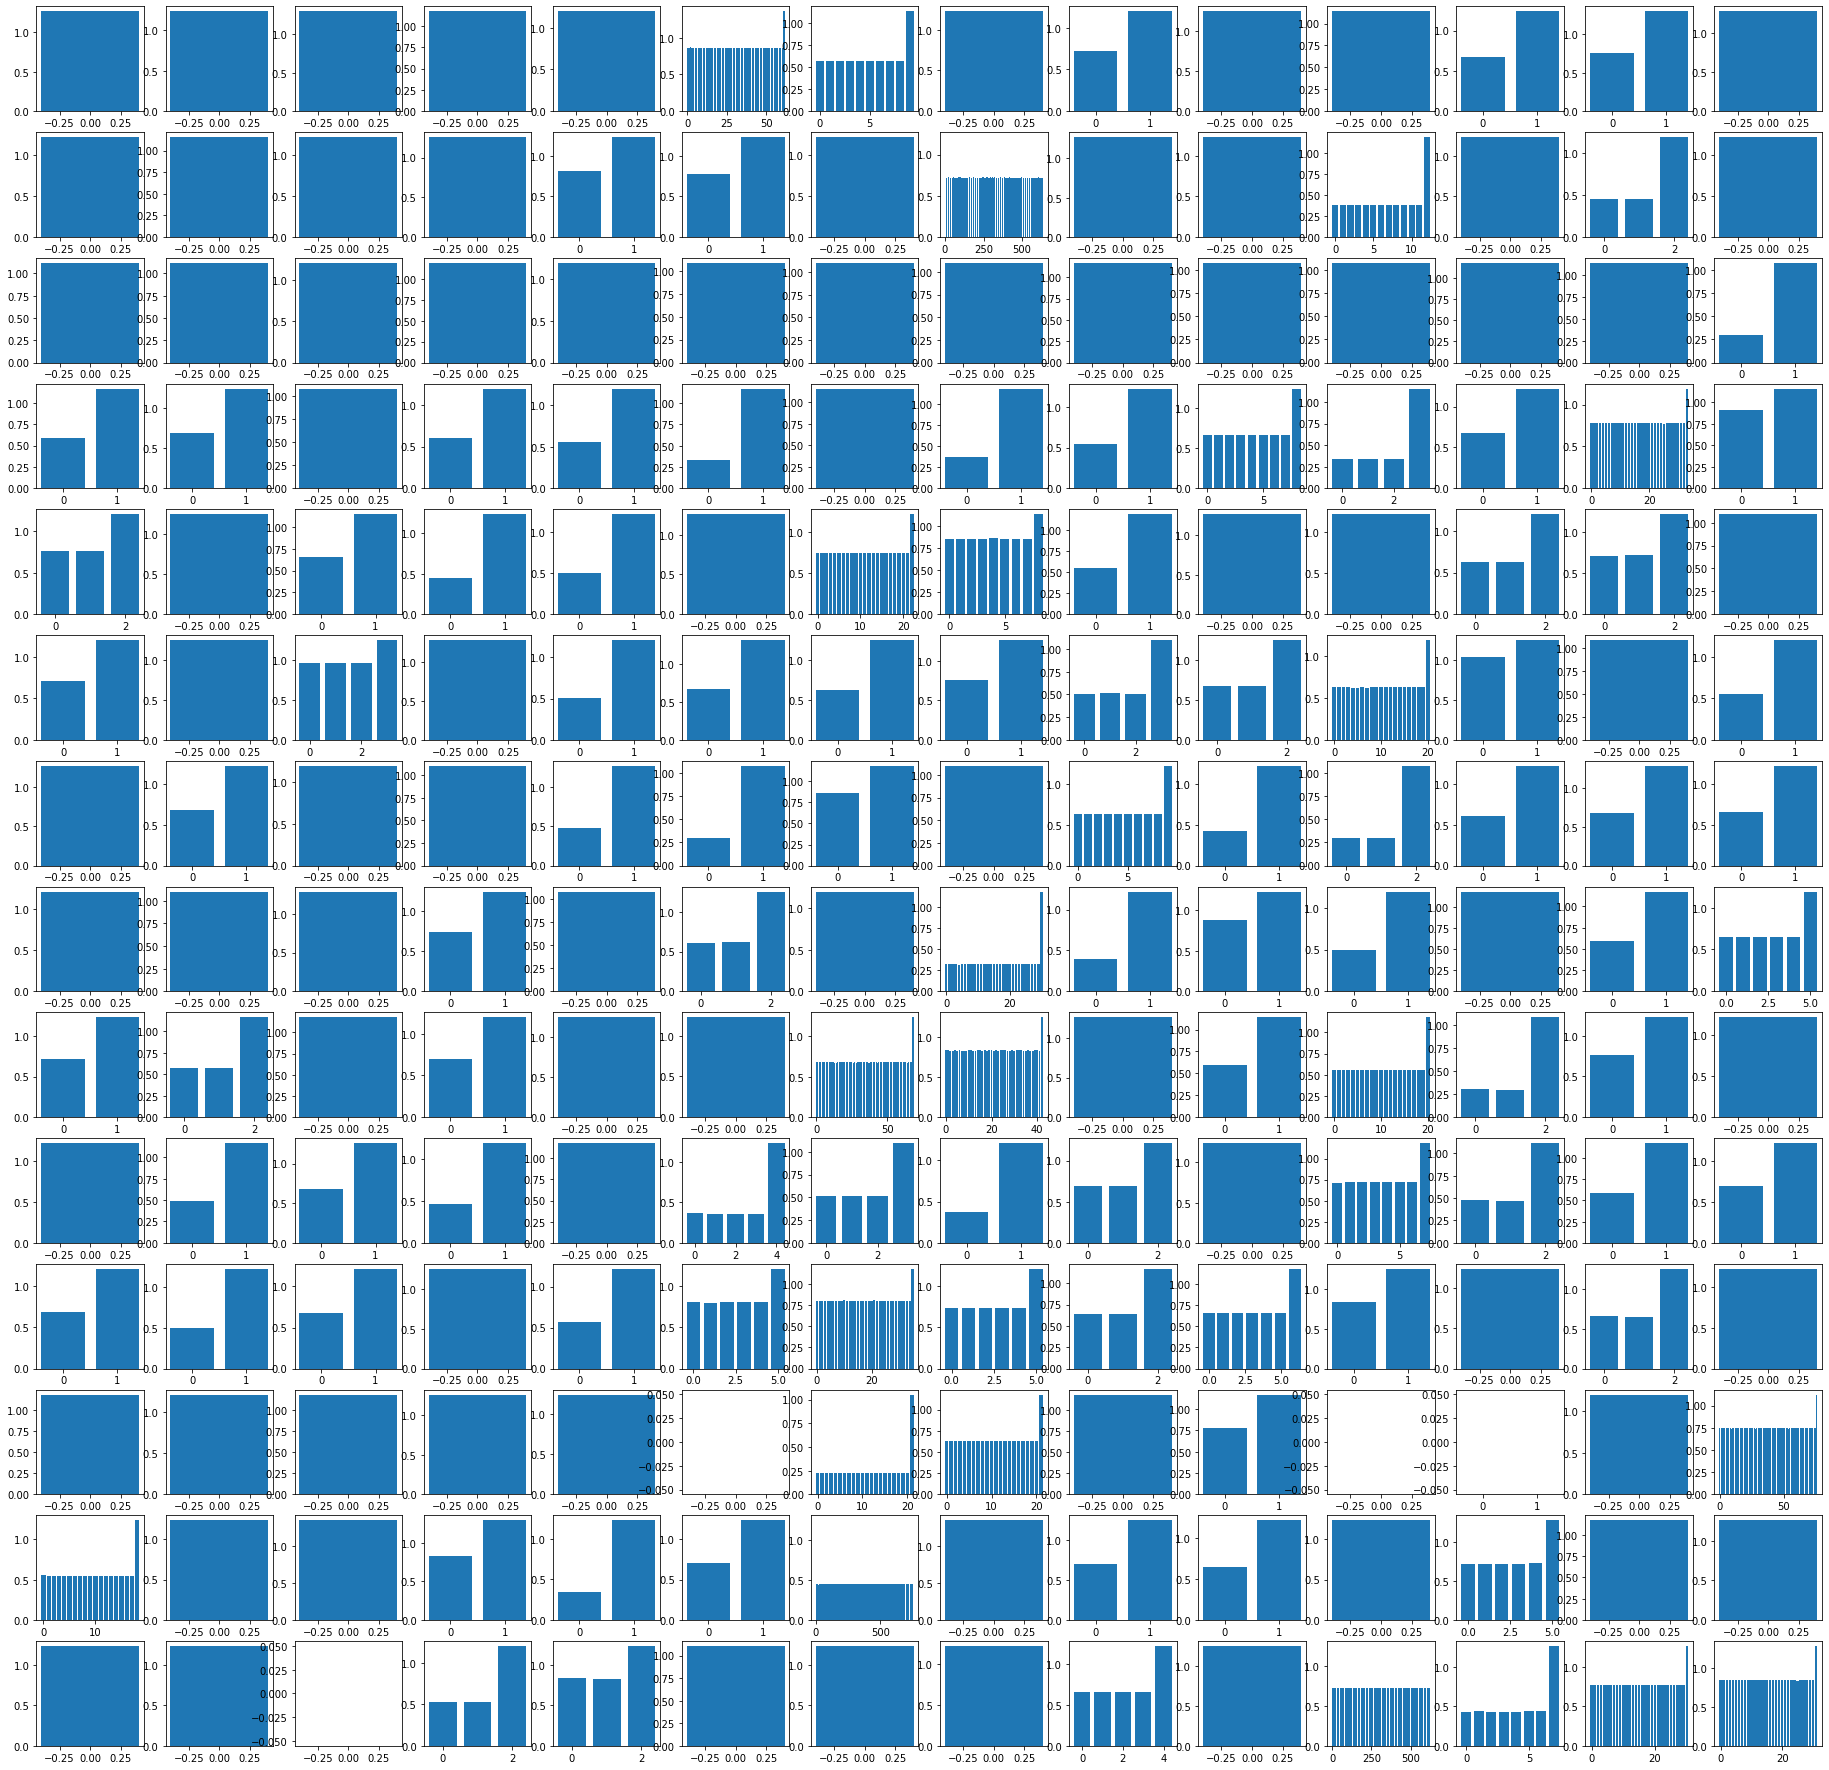

In [39]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.WARNING)

split = 'train'
with open(f"data/features/unsupervised_{split}.pkl", "rb") as f:
    list_of_good_entities = pickle.load(file=f)

row = 14
fig, ax = plt.subplots(row, row, figsize=(32, 32))
for counter_x in range(row):
    for counter_y in range(row):
        x = [y[-3:] for y in list_of_good_entities[counter_x*row + counter_y]['features']]
        z = np.array([y[0] for y in x])
        z[z > 100] = 0
        ax[counter_x, counter_y].bar(range(len(z)), z)

In [ ]:
# after
list_of_good_entities[2]

# Ranking

## Load Data

In [1]:
import pickle
from tqdm import tqdm
import numpy as np
from evaluation import perform_experiment, plot_metrics_over_threshold, crossvalidate_experiment

ImportError: cannot import name 'plot_metrics_over_treshold' from 'evaluation' (/home/aheser/ETH-CS4NLP-22-Project-Linking-GND/evaluation.py)

In [ ]:
d = {"train": {}, "eval": {}}
for split in ["train", "eval"]:
    with open(f"data/features/unsupervised_{split}.pkl", "rb") as f:
        d[split] = pickle.load(file=f)

d_problem = {"train": {}, "eval": {}}
for split in ["train", "eval"]:
    with open(f"data/features/{split}_problematic.pkl", "rb") as f:
        d_problem[split] = pickle.load(file=f)

d_combined = {"train": d["train"] + d_problem["train"], "eval": d["eval"] + d_problem["eval"]}

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

**Best scores I could get so far**

In [4]:
# TODO -> here the arguments are wrong???
ent_scores, ment_scores = perform_experiment(
    keep_empty=True,
    do_sample=True,
    oversampling=3, # Multiple of how often we oversample y = 1
    balance=2, # multiple of y = 0 samples vs y = 1 samples
#     train=d["train"],
#     eval=d["eval"],
    d=d,
    model=ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True),
    n_s=[1,10], # How many candidates do we keep
#     thresholds=[0.5], # Where do we cut off
    thresholds=[0.5], # Where do we cut off
    verbose=False # Print stuff
)

In [7]:
ent_scores, ment_scores = crossvalidate_experiment(
    d = d,
    n_fold = 5,
    keep_empty=True,
    do_sample=True,
    oversampling=2, # Multiple of how often we oversample y = 1
    balance=3, # multiple of y = 0 samples vs y = 1 samples
    model=ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True),
    n_s=[1,10], # How many candidates do we keep
    thresholds=[0.01, 0.1, 0.3,0.5], # Where do we cut off
    verbose=False # Print stuff
)

TypeError: perform_experiment() got an unexpected keyword argument 'tresholds'

In [ ]:
print("\nEntity Level")
for score in ent_scores:
    print("N:", score["top_n"], "threshold:", score["threshold"])
    score["score"].print_scores()

print("Mention Level")
for score in ment_scores:
    print("N:", score["top_n"], "threshold:", score["threshold"])
    score["score"].print_scores()

In [ ]:
print("\nEntity Level")
for score in ent_scores:
    print("N:", score["top_n"], "threshold:", score["threshold"])
    score["score"].print_scores()

print("Mention Level")
for score in ment_scores:
    print("N:", score["top_n"], "threshold:", score["threshold"])
    score["score"].print_scores()

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

models = [
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='squared_error'),
    ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True),
    ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="absolute_error", bootstrap=True),
    ExtraTreesClassifier(n_estimators=100, random_state=0, bootstrap=True),
    ElasticNet(random_state=0)
    ## NN ??
]

model_names = ["GBR", "Tree Reg Squared", "Tree Reg Abs", "Tree Class", "Elastic"]

In [ ]:
models = [ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True)]
model_names = ["Tree Reg Squared"]

In [ ]:
balance_list = [2, 3]
oversampling_list = [2, 3]
n_s = [1,10]
thresholds = [0.01, 0.1, 0.2, 0.5]

In [ ]:
model_results = []

for model, model_name in zip(models, model_names):
    print(model_name)
    results = []
    for data, data_name in zip([d, d_combined], ["cleaned", "combined"]):
        print("Data:", data_name)
        for keep_empty in [True, False]:
            print("keep_empty:", keep_empty)
            for do_sample in [True, False]:
                print("do_sample:", do_sample)
                if do_sample:
                    for balance in balance_list:
                        print("Balance:", balance)
                        for oversampling in oversampling_list:
                            print("Oversampling:", oversampling)
                            ent_scores, ment_scores = crossvalidate_experiment(
                                    d = data,
                                    n_fold = 5,
                                    keep_empty=keep_empty,
                                    do_sample=do_sample, 
                                    oversampling=oversampling, 
                                    balance=balance,
                                    model=model,
                                    n_s=n_s,
                                    thresholds=thresholds,
                                    verbose=False 
                                )
                            results.append({
                                "keep_empty": keep_empty,
                                "do_sample": do_sample,
                                "balance": balance,
                                "oversampling": oversampling,
                                "ent_scores": ent_scores,
                                "ment_scores": ment_scores,
                                "model": model_name,
                                "data": data_name
                            })
                else:
                    balance = 1
                    oversampling = 1 
                    ent_scores, ment_scores = crossvalidate_experiment(
                            d = data,
                            n_fold = 5,
                            keep_empty=keep_empty,
                            do_sample=do_sample, 
                            oversampling=oversampling, 
                            balance=balance,
                            model=model,
                            n_s=n_s,
                            thresholds=thresholds,
                            verbose=False 
                        )
                    results.append({
                        "keep_empty": keep_empty,
                        "do_sample": do_sample,
                        "balance": balance,
                        "oversampling": oversampling,
                        "ent_scores": ent_scores,
                        "ment_scores": ment_scores,
                        "model": model_name,
                        "data": data_name
                    })
    model_results.append(results)

In [ ]:
do_sample = True
keep_empty = True
model = "Tree Reg Squared"
data = "combined"

for balance in balance_list:
    for oversampling in oversampling_list:
        plot_metrics_over_threshold(
            thresholds=thresholds, 
            n_s=n_s, 
            oversampling=oversampling, 
            balance=balance, 
            do_sample=True, 
            keep_empty=True, 
            model=model,
            data=data,
            results=results)

In [ ]:
# top_10 scores are necessarily better than top_1 scores, here we can decide which one we choose to get metrics about
top_n = 1

In [ ]:
def extract(scores, score_name, dict, current_setup, top_n):
    for score in scores:
        score_dict = score["score"].get_score()
        if score["top_n"] == top_n:
            curr_setup["top_n"] = score["top_n"]
            curr_setup["threshold"] = score["threshold"]
            if score_dict[score_name] > dict[f"top_{score_name}"]:
                dict[f"top_{score_name}"] = score_dict[score_name]
                dict[f"top_{score_name}_setup"] = [current_setup]
            elif score_dict[score_name] == dict[f"top_{score_name}"]:
                dict[f"top_{score_name}_setup"].append(current_setup)
    return dict

model_results = []
for model_name in model_names:
    dictionary={
        "ent": {
            "top_F1": 0,
            "top_Recall": 0,
            "top_Precision": 0,
            "top_F1_setup": [],
            "top_Recall_setup": [],
            "top_Precision_setup": []
        },
        "ment": {
            "top_F1": 0,
            "top_Recall": 0,
            "top_Precision": 0,
            "top_F1_setup": [],
            "top_Recall_setup": [],
            "top_Precision_setup": []
        }
    }
    for di in results:
        if di["model"] == model_name:
            for scoring_level in ["ent", "ment"]:
                scores = di[f"{scoring_level}_scores"]
                curr_setup = {
                    "data": di["data"],
                    "do_sample": di["do_sample"],
                    "balance": di["balance"],
                    "oversampling": di["oversampling"],
                    "keep_empty": di["keep_empty"]
                }
                for score_name in ["F1", "Recall", "Precision"]:
                    dictionary[scoring_level] = extract(scores, score_name, dictionary[scoring_level], curr_setup, top_n=top_n )
    model_results.append(dictionary)        


In [ ]:
score = "F1"

In [ ]:
for scores, model_name in zip(model_results, model_names):
    balance = []
    combined = []
    oversampling = []
    keep_empty = []
    do_sample = []
    top_n = []
    thresholds = []
    print(model_name)
    for scoring_level in ["ent", "ment"]:
        print(f"{scoring_level}\t", f"{score}:\t", scores[scoring_level][f"top_{score}"])
        print(f"{scoring_level}\t", f"{score} Setup:")
        for setup in scores[scoring_level][f"top_{score}_setup"]:
            if setup["data"] == "cleaned":
                combined.append(0)
            else:
                combined.append(1)
            balance.append(setup["balance"])
            oversampling.append(setup["oversampling"])
            top_n.append(setup["top_n"])
            thresholds.append(setup["threshold"])
            if setup["do_sample"]:
                do_sample.append(1)
            else:
                do_sample.append(0)
            if setup["keep_empty"]:
                keep_empty.append(1)
            else:
                keep_empty.append(0)
    
        print(f"Number of setups: {len(do_sample)}")

        print("Mean")
        print("sample", np.mean(do_sample))
        print("empty ", np.mean(keep_empty))
        print("combin", np.mean(combined))
        print("tresh ", np.mean(thresholds))
        print("top_n ", np.mean(top_n))
        print("overs ", np.mean(oversampling))
        print("balanc", np.mean(balance))

        print("Median")
        print("sample", np.median(do_sample))
        print("empty ", np.median(keep_empty))
        print("combin", np.median(combined))
        print("tresh ", np.median(thresholds))
        print("top_n ", np.median(top_n))
        print("overs ", np.median(oversampling))
        print("balanc", np.median(balance))
        print("\n\n")
            

After some tests we find:
- ExtraTreesRegressor works best
- with: 
    - Balance = 1
    - Oversampling = 1
    - do_sample = True
    - keep_empty = True
    - threshold = 0.1 or smaller is more stable in advers conditions for balance 1 and oversampling 1 it does not matter -> this makes the regression more stable
    - => n -> does not matter so much can amolst go to 1 !!!!

- problematic entities seem to help 